# Neural network from scratch

We will implement a basic neural network using only NumPy, a Python library providing support for arrays (vectors and matrices) and operations on those arrays.

The neural network code is divided up into the following steps.
* **Network architecture**, where we specify the number of layers and units in each layer.
* **Weight initialization**, where we initialize the weights to small random values.
* **Activation functions**, where we define the activation functions.
* **Forward propagation**, where we specify all the computations associated with a forward pass throught the network.
* **Error/cost function**, where we specify the error/cost function that will be minimized.
* **Performance metric**, where we specify how to measure the networks performance.
* **Back propagation**, where we specify all the computations necessary to update the weights.
* **Training function**, a function that puts together all of the above componets and trains the network.

Beyond the above parts, there is additional code for plotting, training and testing the network.


## Required libraries

Make sure you have the following libraries installed.

* NumPy
* Scikit-learn (sklearn)
* Matplotlib
* Seaborn

In [1]:
import numpy as np
from IPython.display import Image

## Network architecture



![Network architecture](https://drive.google.com/uc?id=1-MSS49rORx9oMw4uBvbckHO1vx1fDV8i)

<b>Figure 1.</b> Example of a dense neural network architecture

The code below specifies an architecture that corresponds to Fig 1.

In [2]:
# 5-layer neural network
nn_architecture = [
    {"input_dim": 2, "output_dim": 4, "activation": "relu"},
    {"input_dim": 4, "output_dim": 6, "activation": "relu"},
    {"input_dim": 6, "output_dim": 6, "activation": "relu"},
    {"input_dim": 6, "output_dim": 4, "activation": "relu"},
    {"input_dim": 4, "output_dim": 1, "activation": "sigmoid"},
]

In [3]:
nn_architecture = [
   {"input_dim": 2, "output_dim": 25, "activation": "relu"},
   {"input_dim": 25, "output_dim": 50, "activation": "relu"},
   {"input_dim": 50, "output_dim": 50, "activation": "relu"},
   {"input_dim": 50, "output_dim": 25, "activation": "relu"},
   {"input_dim": 25, "output_dim": 1, "activation": "sigmoid"},
]

### Question 1
  a) How many weights are there in the first weight layer?

  b) How many weights are there in the whole network?

## Initialize the weights in each layer

The weights are initialized with small random numbers. ```np.random.randn()``` returns samples for the standard normal distribution (approximately from -3 to 3). The weights are stored in a ```dict``` called *weights*, where keys are named, for example, ```W1``` (weight vector for layer 1) and ```b1``` (bias vector for layer 1).

In [4]:
def init_weights(nn_architecture, seed=1):
    """
    """
    # random seed initiation in order to get reproducible results
    np.random.seed(seed)
    # number of layers in our neural network
    number_of_layers = len(nn_architecture)
    # Initialize weight storage
    weights = {}
    
    # iterate over network layers
    for i, layer in enumerate(nn_architecture):
        # layers are numbered from 1
        layer_i = i + 1
        
        # extract the number of units the layer
        layer_input_size = layer["input_dim"]
        layer_output_size = layer["output_dim"]
        
        # initiate the values of the W matrix
        # and vector b for subsequent layers
        weights['W%d' % layer_i] = np.random.randn(layer_output_size, layer_input_size) * 0.1
        weights['b%d' % layer_i] = np.random.randn(layer_output_size, 1) * 0.1
        
    return weights

### Question 2
Inspect the code in the above cell. How many, if any, biases are there in the network?

## Activation functions

We will use only two activation functions: ```sigmoid()``` for the final output (since the network should do binary classification) and ```relu()``` for the hidden nodes. Figure 2 shows these two activation functions and their corresponding derivatives.

![Activations](https://drive.google.com/uc?id=1C-8wXvals_eI--GdJxGfGphLKw1L26uE)

<b>Figure 2.</b> Activation functions used in the network.

In [5]:
def sigmoid(Z):
    """
    for the final output
    """
    return 1/(1+np.exp(-Z))


def relu(Z):
    """
    for the hidden nodes
    """
    
    return np.maximum(0, Z)


def sigmoid_backward(dA, Z):
    """
    """
    sig = sigmoid(Z)
    
    return dA * sig * (1 - sig)


def relu_backward(dA, Z):
    """
    """
    dZ = np.array(dA, copy=True)
    dZ[Z <= 0] = 0;
    
    return dZ

## Forward propagation

To make the code more readable, we divide it up into two functions: ```single_layer_fwdprop()``` and ```full_fwdprop()``` where the latter calls the former.

### Single layer forward propagation

It's a matrix multiplication (```np.dot()```) to which the biases are added, followed by passing the result through an activation function.

In [6]:
def single_layer_fwdprop(A_prev, W_curr, b_curr, activation="relu"):
    """
    """
    # calculate the input value for the activation function
    Z_curr = np.dot(W_curr, A_prev) + b_curr
    
    # selection of activation function
    if activation == "relu":
        activation_func = relu
        
    elif activation == "sigmoid":
        activation_func = sigmoid
        
    else:
        raise Exception('Non-supported activation function')
        
    # return the calculated activation A and the intermediate Z values
    return activation_func(Z_curr), Z_curr

### Full forward propagation

This iterates through the layers (from layer 1 to 5) calling ```single_layer_fwdprop()```. In addition to the predictions, ```A_curr```, a cache, ```cache```, of intermediate values for use by ```single_layer_backprop()``` are returned.

In [7]:
def full_fwdprop(X, weights, nn_architecture):
    """
    """
    # creating a cache to store the information needed for a backward step
    cache = {}
    # X vector is the activation for layer 0 
    A_curr = X
    
    # iteration over network layers
    for i, layer in enumerate(nn_architecture):
        # we number network layers from 1
        layer_i = i + 1
        # transfer the activation from the previous iteration
        A_prev = A_curr
        
        # extraction of the activation function for the current layer
        activ_function_curr = layer["activation"]
        # extraction of W for the current layer
        W_curr = weights["W%d" % layer_i]
        # extraction of b for the current layer
        b_curr = weights["b%d" % layer_i]
        # calculation of activation for the current layer
        A_curr, Z_curr = single_layer_fwdprop(A_prev, W_curr, b_curr, activ_function_curr)
        
        # saving calculated values in the cache
        cache["A%d" % i] = A_prev
        cache["Z%d" % layer_i] = Z_curr
       
    # return a prediction vector and a dictionary containing intermediate values
    return A_curr, cache

## Error/cost function

The error we use here is **binary crossentropy**, suitable of binary classification.



>$error = -\frac{1}{m} [Y \cdot log(\hat{Y}) + (1 - Y) \cdot log(1 - \hat{Y})]$

![Binary crossentropy](./cost_function.gif)

In [8]:
def get_error(Y_hat, Y):
    """
    Error/cost/loss
    
    Binary crossentropy
    """
    # number of examples
    m = Y_hat.shape[1]
    # calculate the error/cost
    error = -1 / m * (np.dot(Y, np.log(Y_hat).T) + np.dot(1 - Y, np.log(1 - Y_hat).T))
    
    return np.squeeze(error)

## Performance metric -- average number of correct predictions

### Probabilities to class
The output of our network (```y_hat```) is a probability that the input belongs to one of two classes. We convert those probabilities to class predictions by thresholding at 0.5. That is, p > 0.5 becomes class 1 and p <= 0.5 class 0.

In [9]:
# helper function that converts probability into class
def prob2class(probs):
    """
    """
    classes = np.copy(probs)
    classes[probs > 0.5] = 1
    classes[probs <= 0.5] = 0
    
    return classes

### Accuracy
The average number of correct classifications.

In [10]:
def get_accuracy(Y_hat, Y):
    """
    """
    Y_hat_ = prob2class(Y_hat)
    
    return (Y_hat_ == Y).all(axis=0).mean()

## Back propagation

As with forward propagation, for readability, we divide it up into two functions: ```single_layer_backprop()``` and ```full_backprop()``` where the latter calls the former.

### Single layer backwards propagation

In [11]:
def single_layer_backprop(dA_curr, W_curr, b_curr, Z_curr, A_prev, activation="relu"):
    """
    """
    # number of examples
    m = A_prev.shape[1]
    
    # select activation function
    if activation == "relu":
        backward_activation_func = relu_backward
    elif activation == "sigmoid":
        backward_activation_func = sigmoid_backward
    else:
        raise Exception('Non-supported activation function')
    
    # calculate the derivative of the activation function
    dZ_curr = backward_activation_func(dA_curr, Z_curr)
    
    # derivative of the matrix W
    dW_curr = np.dot(dZ_curr, A_prev.T) / m
    # derivative of the vector b
    db_curr = np.sum(dZ_curr, axis=1, keepdims=True) / m
    # derivative of the matrix A_prev
    dA_prev = np.dot(W_curr.T, dZ_curr)

    return dA_prev, dW_curr, db_curr

### Full backwards propagation

In [12]:
def full_backprop(Y_hat, Y, cache, weights, nn_architecture):
    """
    """
    gradients = {}
    
    # number of examples
    m = Y.shape[1]
    # a hack ensuring the same shape of the prediction vector and labels vector
    Y = Y.reshape(Y_hat.shape)
    
    # Initiate gradient descent
    dA_prev = - (np.divide(Y, Y_hat) - np.divide(1 - Y, 1 - Y_hat));
    
    for prev_layer_i, layer in reversed(list(enumerate(nn_architecture))):
        # layers are numbered from 1
        curr_layer_i = prev_layer_i + 1
        # get of the activation function for the current layer
        activ_function_curr = layer["activation"]
        
        dA_curr = dA_prev
        
        A_prev = cache["A%d" % prev_layer_i]
        Z_curr = cache["Z%d" % curr_layer_i]
        
        W_curr = weights["W%d" % curr_layer_i]
        b_curr = weights["b%d" % curr_layer_i]
        
        dA_prev, dW_curr, db_curr = single_layer_backprop(
            dA_curr, W_curr, b_curr, Z_curr, A_prev, activ_function_curr)
        
        gradients["dW%d" % curr_layer_i] = dW_curr
        gradients["db%d" % curr_layer_i] = db_curr
    
    return gradients

### Updating the weights

In [13]:
def update(weights, gradients, nn_architecture, learning_rate):

    # iteration over network layers
    for layer_i, layer in enumerate(nn_architecture, 1):
        weights["W%d" % layer_i] -= learning_rate * gradients["dW%d" % layer_i]        
        weights["b%d" % layer_i] -= learning_rate * gradients["db%d" % layer_i]

    return weights

## Function to train the network

In [14]:
def train(X, Y, nn_architecture, n_epochs, learning_rate, verbose=False, callback=None):
    """
    """
    # initiation of neural net weights
    weights = init_weights(nn_architecture, 2)
    # initiation of lists storing the history 
    # of metrics calculated during the learning process 
    error_history = []
    accuracy_history = []
    
    # performing calculations for subsequent iterations
    for i in range(n_epochs):
        # step forward
        Y_hat, cache = full_fwdprop(X, weights, nn_architecture)
        
        # calculating metrics and saving them in history
        error = get_error(Y_hat, Y)
        error_history.append(error)
        accuracy = get_accuracy(Y_hat, Y)
        accuracy_history.append(accuracy)
        
        # step backward - calculating gradient
        gradients = full_backprop(Y_hat, Y, cache, weights, nn_architecture)
        # updating model state
        weights = update(weights, gradients, nn_architecture, learning_rate)
        
        if (i % 100) == 0:
            if verbose:
                print("Epoch: {:05} - error: {:.5f} - accuracy: {:.5f}".format(i+1, error, accuracy))

        if (i % 100) == 0:
            if callback is not None:
                callback(i, weights, error)                
            
    return weights

## Train and test the neural network

### Generate a dataset using sklearn

First we need some artificial data to test our network. For simplicity (and network architecture), we will have two classes (i.e. binary classification) and 2-dimensional inputs (i.e. each exemplar is made up of 2 values). We can use ```sklearn.datasets.make_moons()``` for this.

In [15]:
from sklearn.datasets import make_moons
from sklearn.model_selection import train_test_split


# number of examples in the data set
n_examples = 1000
# fraction of the data set that goes into the test set
test_sz = 0.1

X, y = make_moons(n_samples=n_examples, noise=0.2, random_state=1)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_sz, random_state=2)

### Plotting

#### Helper function to make nice plots

In [16]:
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import cm
from mpl_toolkits.mplot3d import Axes3D
sns.set_style("whitegrid")

# the function making up the graph of a dataset
def make_plot(X, y, plot_name, fname=None, XX=None, YY=None, preds=None, dark=False):
    """
    """
    if (dark):
        plt.style.use('dark_background')
    else:
        sns.set_style("whitegrid")
    plt.figure(figsize=(16,12))
    axes = plt.gca()
    axes.set(xlabel="$X_1$", ylabel="$X_2$")
    plt.title(plot_name, fontsize=30)
    plt.subplots_adjust(left=0.20)
    plt.subplots_adjust(right=0.80)
    
    if XX is not None and YY is not None and preds is not None:
        plt.contourf(XX, YY, preds.reshape(XX.shape), 25, alpha=1, cmap=cm.Spectral)
        plt.contour(XX, YY, preds.reshape(XX.shape), levels=[.5], cmap="Greys", vmin=0, vmax=.6)
        
    plt.scatter(X[:, 0], X[:, 1], c=y.ravel(), s=40, cmap=plt.cm.Spectral, edgecolors='none')
    
    if fname:
        plt.savefig(fname)
        plt.close()

#### Visualize the data set

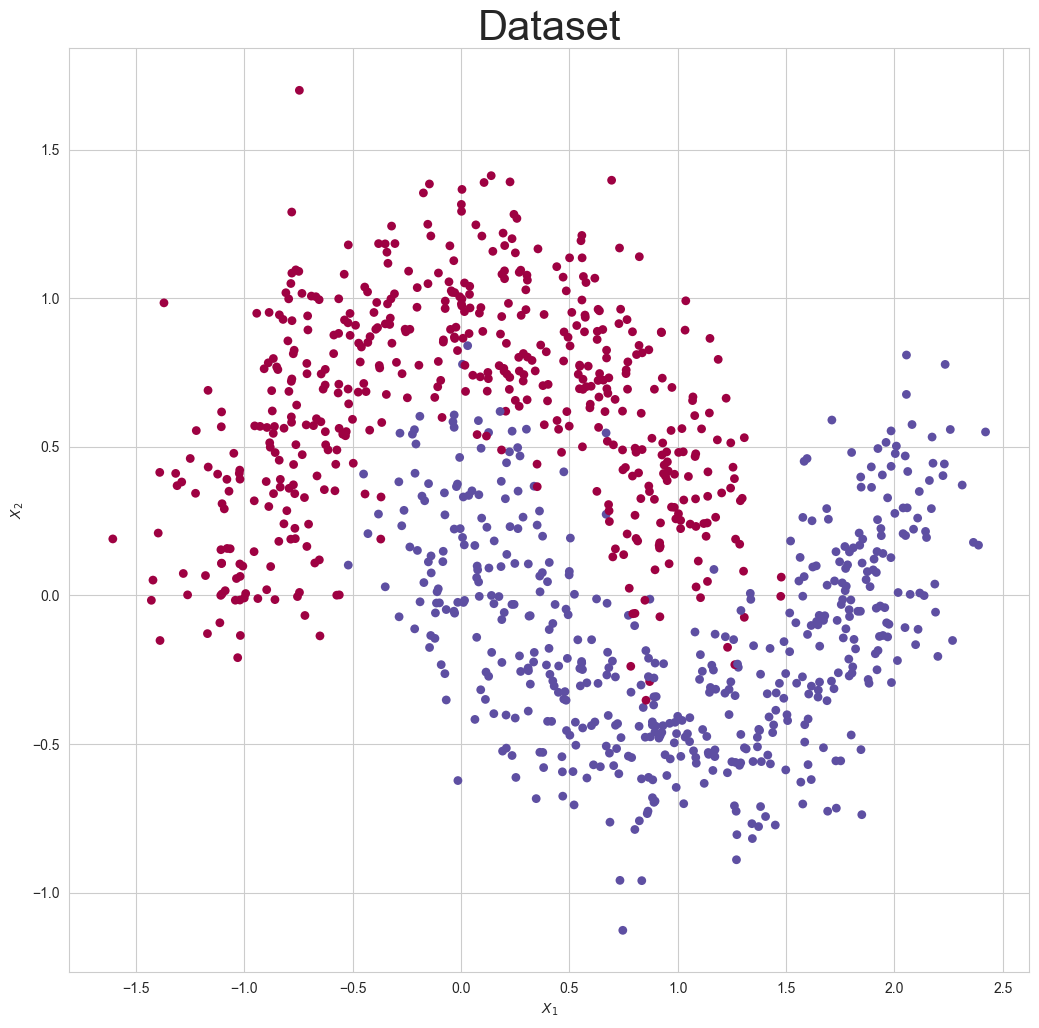

In [17]:
make_plot(X, y, "Dataset")

### Question 3
Given this data set, could a linear decision boundary give a good separation of the two classes?

### Train the network

In [18]:
# Training
# 
n_epochs = 5000
learning_rate = 0.01
weights = train(X_train.T, y_train.reshape((1, -1)), nn_architecture, n_epochs, learning_rate, verbose=True)

Epoch: 00001 - error: 0.69359 - accuracy: 0.50556
Epoch: 00101 - error: 0.69330 - accuracy: 0.50556
Epoch: 00201 - error: 0.69305 - accuracy: 0.50556
Epoch: 00301 - error: 0.69283 - accuracy: 0.50556
Epoch: 00401 - error: 0.69261 - accuracy: 0.50556
Epoch: 00501 - error: 0.69241 - accuracy: 0.50556
Epoch: 00601 - error: 0.69221 - accuracy: 0.50556
Epoch: 00701 - error: 0.69200 - accuracy: 0.50556
Epoch: 00801 - error: 0.69178 - accuracy: 0.50556
Epoch: 00901 - error: 0.69153 - accuracy: 0.50556
Epoch: 01001 - error: 0.69124 - accuracy: 0.50556
Epoch: 01101 - error: 0.69090 - accuracy: 0.50556
Epoch: 01201 - error: 0.69050 - accuracy: 0.50556
Epoch: 01301 - error: 0.69004 - accuracy: 0.50556
Epoch: 01401 - error: 0.68948 - accuracy: 0.50667
Epoch: 01501 - error: 0.68881 - accuracy: 0.54667
Epoch: 01601 - error: 0.68798 - accuracy: 0.65222
Epoch: 01701 - error: 0.68693 - accuracy: 0.74111
Epoch: 01801 - error: 0.68556 - accuracy: 0.79222
Epoch: 01901 - error: 0.68368 - accuracy: 0.84000


### Make predictions

In [19]:
# Predictions
Y_test_hat, _ = full_fwdprop(X_test.T, weights, nn_architecture)

In [20]:
Y_test_hat[:10]

array([[0.97918615, 0.97699371, 0.08259484, 0.01852193, 0.96673956,
        0.07518118, 0.02447987, 0.88644169, 0.02411662, 0.97888979,
        0.98092526, 0.71092049, 0.92859234, 0.05667701, 0.36402581,
        0.09236202, 0.00733482, 0.96219994, 0.27784761, 0.00922203,
        0.05446739, 0.82705942, 0.07807974, 0.31472592, 0.1886551 ,
        0.97557229, 0.39447151, 0.0170383 , 0.05667043, 0.00775848,
        0.07629492, 0.95900168, 0.85079804, 0.83219128, 0.03417846,
        0.18605867, 0.98242337, 0.97848943, 0.33961489, 0.01004291,
        0.9382873 , 0.94984598, 0.01687254, 0.84232732, 0.00891248,
        0.92007646, 0.00764484, 0.9807742 , 0.04439775, 0.72381988,
        0.0274443 , 0.0086992 , 0.58076087, 0.0206329 , 0.0151318 ,
        0.16563492, 0.33766204, 0.12336932, 0.97985212, 0.3613215 ,
        0.97630296, 0.97673519, 0.85306624, 0.06337045, 0.03354169,
        0.78837334, 0.0049675 , 0.94310958, 0.02873509, 0.62864098,
        0.00720549, 0.04695296, 0.06045143, 0.01

### Check the performance on the test set

In [21]:
# Accuracy achieved on the test set
acc_test = get_accuracy(Y_test_hat, y_test.reshape((1, -1)))
print("Test set accuracy: {:.2f}".format(acc_test))

Test set accuracy: 0.87


### Question 4
 a) What accuracy did you get?

 b) Is this good?


### Question 5
To get better pefromance you can increase the capacity of the network. This can be done by increasing its size.
 * Go back to the cell where the network architecture was defined (i.e. the second cell, right below **Figure 1**).
 * Change the number of neurons in the first hidden layer from 4 to 25, in the second hidden layer from 6 to 50, in the third hidden layer from 6 to 50 and in the final fourth hidden layer change the number of neurons from 4 to 25. The new architecture should look like this:
```
  nn_architecture = [
      {"input_dim": 2, "output_dim": 25, "activation": "relu"},
      {"input_dim": 25, "output_dim": 50, "activation": "relu"},
      {"input_dim": 50, "output_dim": 50, "activation": "relu"},
      {"input_dim": 50, "output_dim": 25, "activation": "relu"},
      {"input_dim": 25, "output_dim": 1, "activation": "sigmoid"},
  ]
```
 * Run all the cells again.

 a) What accuracy do you get with a larger capacity network? 

 b) Is this good?

## Visualisation of the learning process

### Settings

In [22]:
# boundary of the graph
GRID_X_START = -1.5
GRID_X_END = 2.5
GRID_Y_START = -1.0
GRID_Y_END = 2
# output directory (the folder must be created in the current working directory)
OUTPUT_DIR = "./fig/"

In [23]:
# test is OUTPUT_DIR was created
import os
if not os.path.isdir(OUTPUT_DIR):
  print('Make the directory fig in the current working directory.')

Make the directory fig in the current working directory.


### Grid boundaires

In [24]:
grid = np.mgrid[GRID_X_START:GRID_X_END:100j,GRID_Y_START:GRID_Y_END:100j]
grid_2d = grid.reshape(2, -1).T
XX, YY = grid

### Callback function for plotting changes during training

In [25]:
import os

def callback(i, weights, error):
    """
    """
    plot_title = "Model - epoch: %05d - error: %1.4f" % (i, error)
    fname = "model_{:05}.png".format(i//50)
    fpath = os.path.join(OUTPUT_DIR, fname)
    prediction_probs, _ = full_fwdprop(grid_2d.T, weights, nn_architecture)
    prediction_probs = prediction_probs.reshape(prediction_probs.shape[1], 1)
    make_plot(X_test, y_test, plot_title, fname=fpath, XX=XX, YY=YY, preds=prediction_probs, dark=True)

In [27]:
if not os.path.exists("./fig"):
    os.makedirs("./fig")

In [28]:
# Training
n_epochs = 10000
learning_rate = 0.01
# weights = train(np.transpose(X_train), np.transpose(y_train.reshape((y_train.shape[0], 1))), NN_ARCHITECTURE, 10000, 0.01, False, callback_numpy_plot)
weights = train(X_train.T, y_train.reshape((1, -1)), nn_architecture, n_epochs, learning_rate, verbose=False, callback=callback)

In [29]:
# Predictions
Y_test_hat, _ = full_fwdprop(X_test.T, weights, nn_architecture)

In [30]:
# Accuracy achieved on the test set
acc_test = get_accuracy(Y_test_hat, y_test.reshape((1, -1)))
print("Test set accuracy: {:.2f}".format(acc_test))

Test set accuracy: 0.94
